In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Generate synthetic linear data
np.random.seed(42)
N = 100  # Number of data points
x = np.random.uniform(0, 10, N)
true_w0 = 2.0  # True intercept
true_w1 = 0.5  # True slope
noise = np.random.normal(0, 1, N)
y = true_w0 + true_w1 * x + noise  # Observations with noise

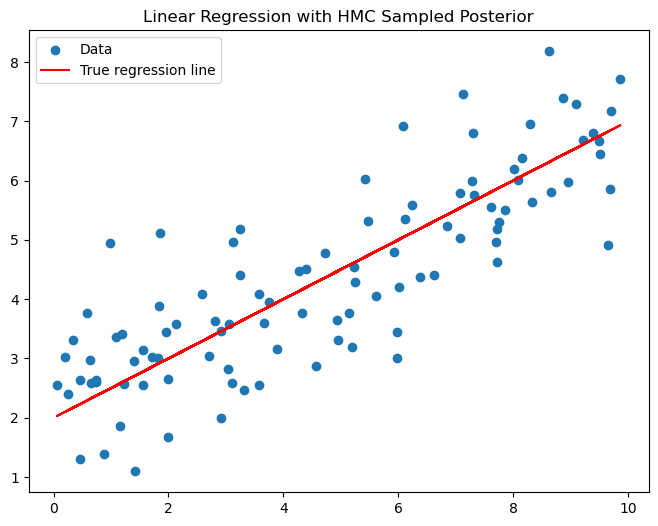

In [3]:
# Plot regression line with posterior samples
plt.figure(figsize=(8, 6))
plt.scatter(x, y, label='Data')
plt.plot(x, true_w0 + true_w1 * x, label='True regression line', color='r')
plt.title('Linear Regression with HMC Sampled Posterior')
plt.legend()
plt.show()

Let's implement the HMC algorithm. Let's first consider the case when the sigma is known. That way, we only need to estimate the coefficients of teh regression line.

In [4]:
# Define the loglikelihood for the data
def log_likelihood(w0, w1, x, y, sigma_y=1.0):
    y_pred = w0 + w1 * x
    return -0.5 * np.sum(((y - y_pred) / sigma_y) ** 2) - N * np.log(sigma_y * np.sqrt(2 * np.pi))

In [5]:
w0 = 1
w1 = 0.5

In [6]:
log_likelihood_output = log_likelihood(w0, w1, x, y, sigma_y=1.0)

In [7]:
log_likelihood_output

-183.0411562991285

In [8]:
# Define log-prior (Gaussian priors on w0 and w1 with variance sigma_prior^2)
def log_prior(w0, w1, sigma_prior=10.0):
    return -0.5 * ((w0 / sigma_prior) ** 2 + (w1 / sigma_prior) ** 2)

In [9]:
log_prior_output = log_prior(w0, w1 , 10)

In [10]:
log_prior_output

-0.006250000000000001

In [11]:
# Log-posterior is the sum of log-likelihood and log-prior
def log_posterior(w0, w1, x, y, sigma_y=1.0, sigma_prior=10.0):
    return log_likelihood(w0, w1, x, y, sigma_y) + log_prior(w0, w1, sigma_prior)

In [12]:
log_posterior_output = log_posterior(w0, w1, x, y, sigma_y=1.0, sigma_prior=10.0)

In [13]:
log_posterior_output

-183.04740629912848

In [14]:
# Gradient of the log-likelihood
def grad_log_likelihood(w0, w1, x, y, sigma_y=1.0):
    y_pred = w0 + w1 * x
    grad_w0 = np.sum((y - y_pred) / sigma_y**2)
    grad_w1 = np.sum((y - y_pred) * x / sigma_y**2)
    return np.array([grad_w0, grad_w1])

In [15]:
grad_log_likelihood_output = grad_log_likelihood(w0, w1, x, y, sigma_y=1.0)

In [16]:
grad_log_likelihood_output

array([ 99.89196398, 429.38977045])

In [17]:
# Gradient of the log-prior (Gaussian prior)
def grad_log_prior(w0,w1, sigma_prior=10.0):
    return -w0 / sigma_prior**2 - w1 / sigma_prior**2

In [18]:
grad_log_prior_output = grad_log_prior(w0,w1, sigma_prior=10.0)

In [19]:
grad_log_prior_output

-0.015

In [20]:
# Gradient of the log-posterior
def grad_log_posterior(w0, w1, x, y, sigma_y=1.0, sigma_prior=10.0):
    return grad_log_likelihood(w0, w1, x, y, sigma_y) + grad_log_prior(w0, w1, sigma_prior)

In [21]:
grad_log_posterior_output = grad_log_posterior(w0, w1, x, y, sigma_y=1.0, sigma_prior=10.0)

In [22]:
grad_log_posterior_output

array([ 99.87696398, 429.37477045])

In [23]:
# Hamiltonian Monte Carlo algorithm
def hmc(log_posterior, grad_log_posterior, x, y, num_samples, epsilon, L, initial_w0, initial_w1, sigma_y=1.0, sigma_prior=10.0):
    samples = []
    current_h = []
    proposed_h =[]
    prob = []
    current_w0 = initial_w0
    current_w1 = initial_w1
    
    for i in range(num_samples):
        # Step 1: Sample momentum from a standard normal distribution
        current_momentum = np.random.normal(0, 1, size=2)

        # Step 2: Simulate Hamiltonian dynamics using leapfrog method
        new_w0 = current_w0
        new_w1 = current_w1
        new_momentum = current_momentum.copy()

        # Half step for momentum
        new_momentum -= 0.5 * epsilon * grad_log_posterior(new_w0,new_w1, x, y, sigma_y, sigma_prior)
        
        # Full steps for position and momentum
        for _ in range(L):
            # Full step for position
            new_w0 += epsilon * new_momentum[0]
            new_w1 += epsilon * new_momentum[1]
            # Full step for momentum (except at last step)
            if _ != L - 1:
                new_momentum -= epsilon * grad_log_posterior(new_w0,new_w1, x, y, sigma_y, sigma_prior)
        
        # Half step for momentum (last step)
        new_momentum -= 0.5 * epsilon * grad_log_posterior(new_w0,new_w1, x, y, sigma_y, sigma_prior)

        # Step 3: Compute the Hamiltonians for the current and proposed states
        current_hamiltonian = -log_posterior(current_w0,current_w1, x, y, sigma_y, sigma_prior) + 0.5 * np.sum(current_momentum ** 2)
        proposed_hamiltonian = -log_posterior(new_w0,new_w1, x, y, sigma_y, sigma_prior) + 0.5 * np.sum(new_momentum ** 2)

        # Step 4: Metropolis-Hastings acceptance criterion
        acceptance_prob = np.exp(current_hamiltonian - proposed_hamiltonian)
        if np.random.uniform(0, 1) < acceptance_prob:
            current_w0 = new_w0 # Accept new position
            current_w1 = new_w1

        # Store the sample
        samples.append((current_w0, current_w1))
        current_h.append(current_hamiltonian)
        proposed_h.append(proposed_hamiltonian)
        prob.append(acceptance_prob)

    return np.array(samples), current_h, proposed_h,prob

In [24]:
# HMC parameters
num_samples = 50000  # Number of samples to generate
epsilon = 0.0001  # Smaller step size for the leapfrog integrator
L = 20  # Larger number of leapfrog steps to ensure good exploration
initial_w0 = 0.5 # Initial guess for w0 and w1
initial_w1 = 0.5

In [25]:
%%time

# Run HMC
samples = hmc(log_posterior, grad_log_posterior, x, y, num_samples, epsilon, L, initial_w0, initial_w1)

# Extract samples for w0 and w1
w0_samples = samples[0][:, 0]
w1_samples = samples[0][:, 1]

current_h_vals = samples[1]
proposed_h_vals = samples[2]
acc_probs = samples[3]

CPU times: user 18.1 s, sys: 546 ms, total: 18.7 s
Wall time: 18.2 s


In [26]:
# acc_probs

In [27]:
# proposed_h_vals

In [28]:
# current_h_vals

In [29]:
w0_samples

array([0.49972693, 0.49972693, 0.49972693, ..., 2.20209462, 2.20149456,
       2.20243006])

In [30]:
w1_samples

array([0.5015827 , 0.5015827 , 0.5015827 , ..., 0.45349922, 0.45352235,
       0.45454811])

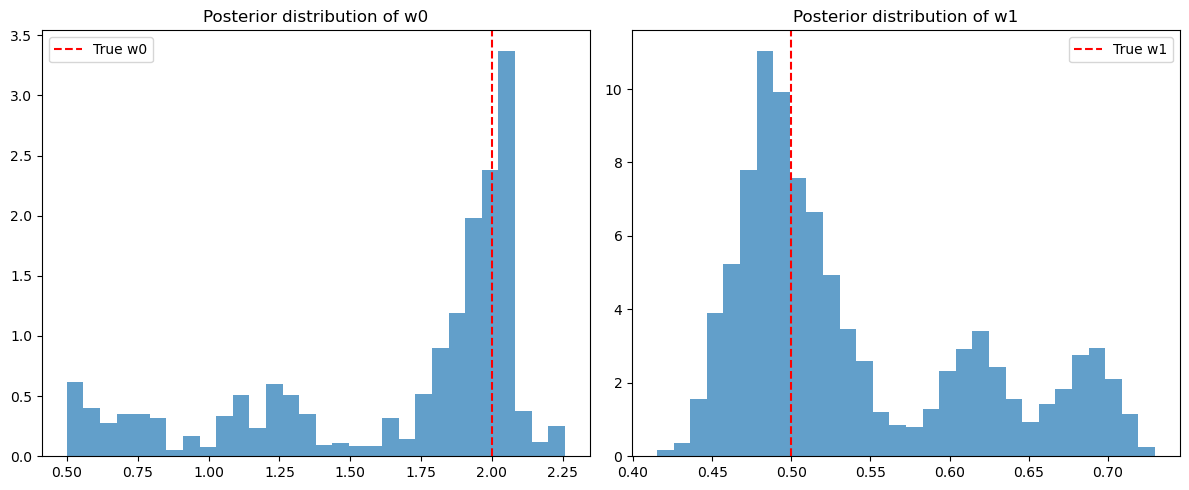

In [31]:
# Plot posterior distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(w0_samples, density=True, bins = 30, alpha=0.7)
plt.axvline(true_w0, color='r', linestyle='--', label='True w0')
plt.title('Posterior distribution of w0')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(w1_samples, density=True, bins = 30, alpha=0.7)
plt.axvline(true_w1, color='r', linestyle='--', label='True w1')
plt.title('Posterior distribution of w1')
plt.legend()

plt.tight_layout()
plt.show()